In [1]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN, Transformer
from trainer import Trainer
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = '/Users/julianyocum/Projects/grid-pattern-formation/models/'
options.n_steps = 5000      # number of training steps
options.batch_size = 100      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'Transformer'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 0   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

# added
options.device = 'mps'

options.run_ID = generate_run_ID(options)
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
if options.RNN_type == 'RNN':
    model = RNN(options, place_cells).to(options.device)
elif options.RNN_type == 'Transformer':
    model = Transformer(options, place_cells).to(options.device)
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

# Load example weights stored on github
# weight_dir = options.save_dir + '/example_trained_weights.npy'
# load_trained_weights(model, trainer, weight_dir)

/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Restored trained model from /Users/julianyocum/Projects/grid-pattern-formation/models/Transformer_steps_5000_sequence_20_batch_100_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_0/most_recent_model.pth


Collect grid cell data from model.

In [2]:
model.eval()
gen = trajectory_generator.get_generator()
n_steps = 20
tbar = tqdm(range(n_steps), desc='Collecting trajectories', position=0, leave=True)
gs_data = []
for step_idx in tbar:
    inputs, pc_outputs, pos = next(gen)
    pos = pos.cpu()
    pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs)).cpu()
    us = place_cells.us.cpu()
    gs = model.g(inputs).cpu().permute(1,0,2)
    gs = gs.flatten(start_dim=0,end_dim=1)
    gs_data.append(gs)
gs_data = torch.cat(gs_data, dim=0)
gs_data = gs_data.detach()
gs_data = gs_data.to(device='mps')

In [3]:
gs_data

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0340],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0588],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0700]],
       device='mps:0')

In [4]:
gs_data.shape

torch.Size([40000, 4096])

Train an SAE.

In [5]:
from dictionary_learning import ActivationBuffer, AutoEncoder, AutoEncoderNew
from dictionary_learning.trainers import StandardTrainer, StandardTrainerAprilUpdate
from dictionary_learning.training import trainSAE

# make torch tensor dataloader
gs_dataloader = torch.utils.data.DataLoader(gs_data, batch_size=100, shuffle=True)


In [6]:
trainer_cfg = {
    "trainer": StandardTrainerAprilUpdate,
    "dict_class": AutoEncoderNew,
    "activation_dim": options.Ng,
    "dict_size": options.Ng * 4,
    "lr": 1e-3,
    "device": 'mps',
    "steps": 1000,
    "layer": 1,
    "lm_name": "SAE",
    "warmup_steps": 50,
    "sparsity_warmup_steps": 50,
}

Ns = trainer_cfg['dict_size']

# train the sparse autoencoder (SAE)
ae = trainSAE(
    data=gs_dataloader,  # you could also use another (i.e. pytorch dataloader) here instead of buffer
    trainer_configs=[trainer_cfg],
    steps=trainer_cfg["steps"],
    save_dir='/Users/julianyocum/Projects/grid-pattern-formation/SAEs/',
    use_wandb=True,
    wandb_project='grid-cells',
    log_steps=10,
)

/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/nnsight/__init__.py:180: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


save /Users/julianyocum/Projects/grid-pattern-formation/SAEs/trainer_0


  3%|▎         | 33/1000 [00:05<01:56,  8.27it/s]wandb: Tracking run with wandb version 0.19.7
wandb: Run data is saved locally in /Users/julianyocum/Projects/grid-pattern-formation/wandb/run-20250228_200609-703ljk91
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run StandardTrainerAprilUpdate
wandb: ⭐️ View project at https://wandb.ai/juliany-university-of-california-berkeley/grid-cells
wandb: 🚀 View run at https://wandb.ai/juliany-university-of-california-berkeley/grid-cells/runs/703ljk91
 40%|████      | 400/1000 [00:52<01:19,  7.59it/s]
wandb: updating run config
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: frac_variance_explained ▁▂▄▅▆▇▇▇▇▇▇▇▇▇█▇████████████████████████
wandb:                      l0 ▆█▇▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                 l2_loss █▇▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    loss █▆▅▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 

In [7]:
# load ae
ae_state_dict = torch.load('/Users/julianyocum/Projects/grid-pattern-formation/SAEs/trainer_0/ae.pt')

# load into AutoEncoder
ae = AutoEncoderNew(options.Ng, Ns)
ae.load_state_dict(ae_state_dict)
ae.to('mps')

# test
gs_out = ae.forward(gs_data[0])


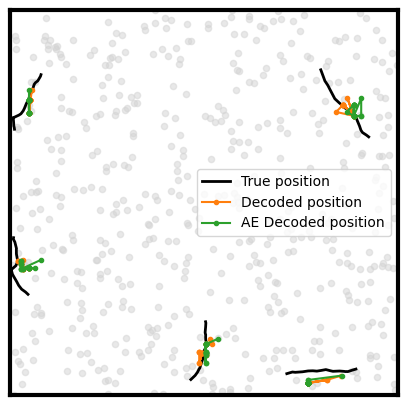

In [8]:
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs)).cpu()
ae_pred_pos = place_cells.get_nearest_cell_pos(model.decoder2(ae(model.g(inputs)))).cpu()
us = place_cells.us.cpu()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[:,i,0], pos[:,i,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    plt.plot(ae_pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C2', label='AE Decoded position',)
    if i==0:
        plt.legend()
plt.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2]);

# Ratemaps

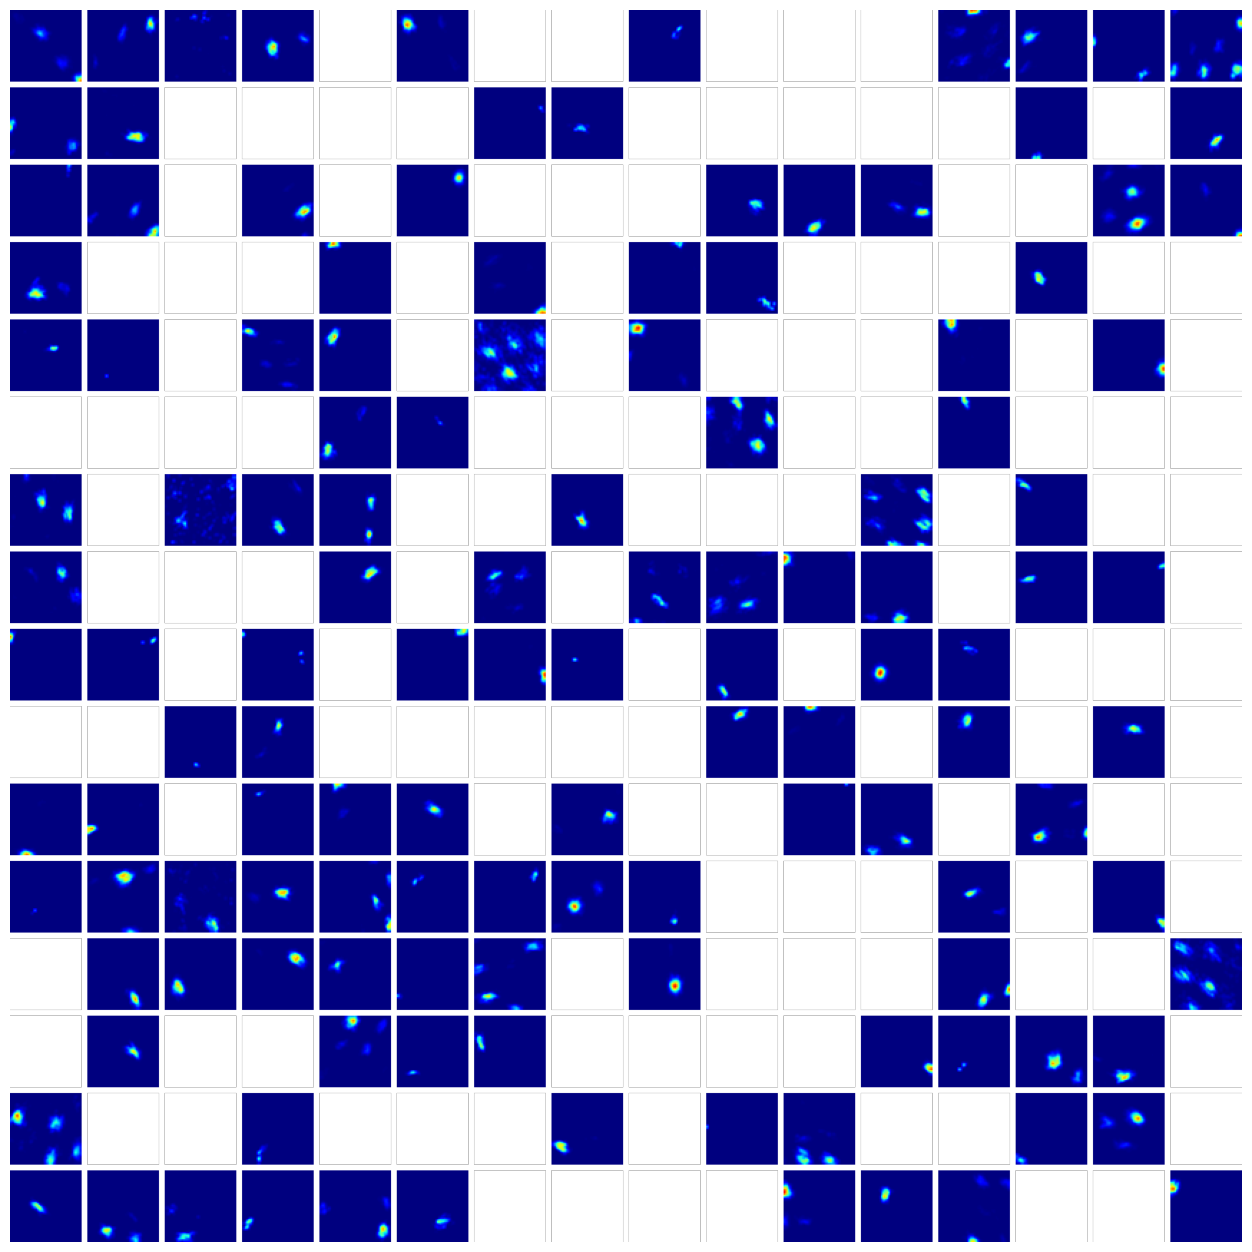

In [9]:
from visualize import compute_ratemaps, plot_ratemaps, compute_ae_ratemaps
res = 50
n_avg = 100
Ng = options.Ng
activations, rate_map, g, pos = compute_ae_ratemaps(model,
                                                 ae,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ns=Ns)

# Compute a set of lo-res maps to use for evalutaing grid score
lo_res = 20
_, rate_map_lores, _, _ = compute_ae_ratemaps(model,
                                         ae,
                                         trajectory_generator,
                                         options,
                                         res=lo_res,
                                         n_avg=n_avg,
                                         Ns=Ns)
n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

In [10]:
activations.shape

(16384, 50, 50)

## Grid scores

In [11]:
from scores import GridScorer

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width=options.box_width
box_height=options.box_height
coord_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(lo_res, coord_range, masks_parameters)

score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
      *[scorer.get_scores(rm.reshape(lo_res, lo_res)) for rm in tqdm(rate_map_lores)])

100%|██████████| 16384/16384 [01:41<00:00, 161.26it/s]


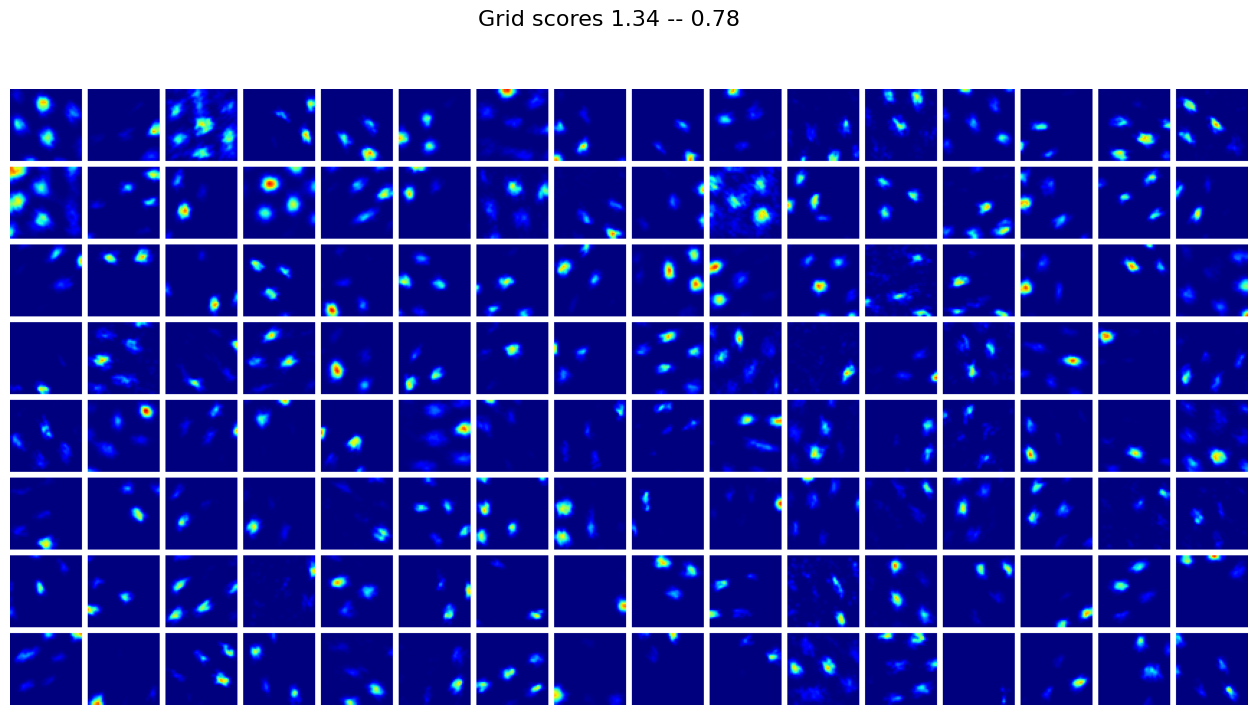

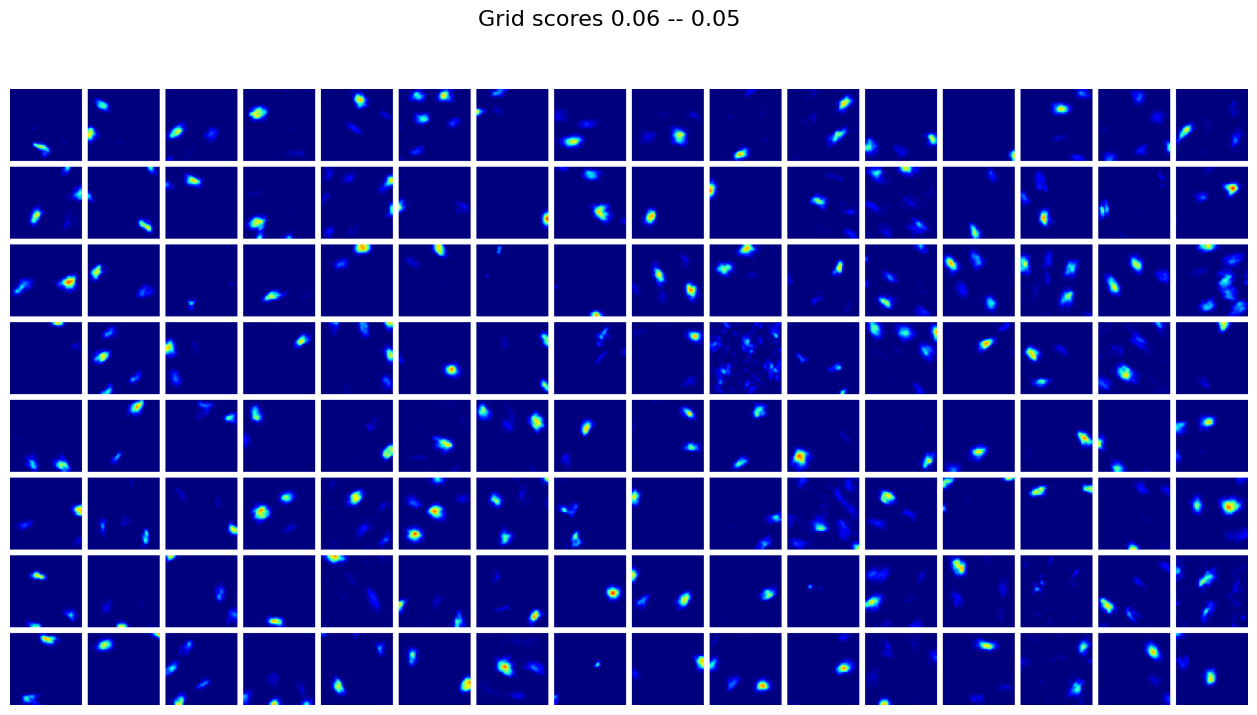

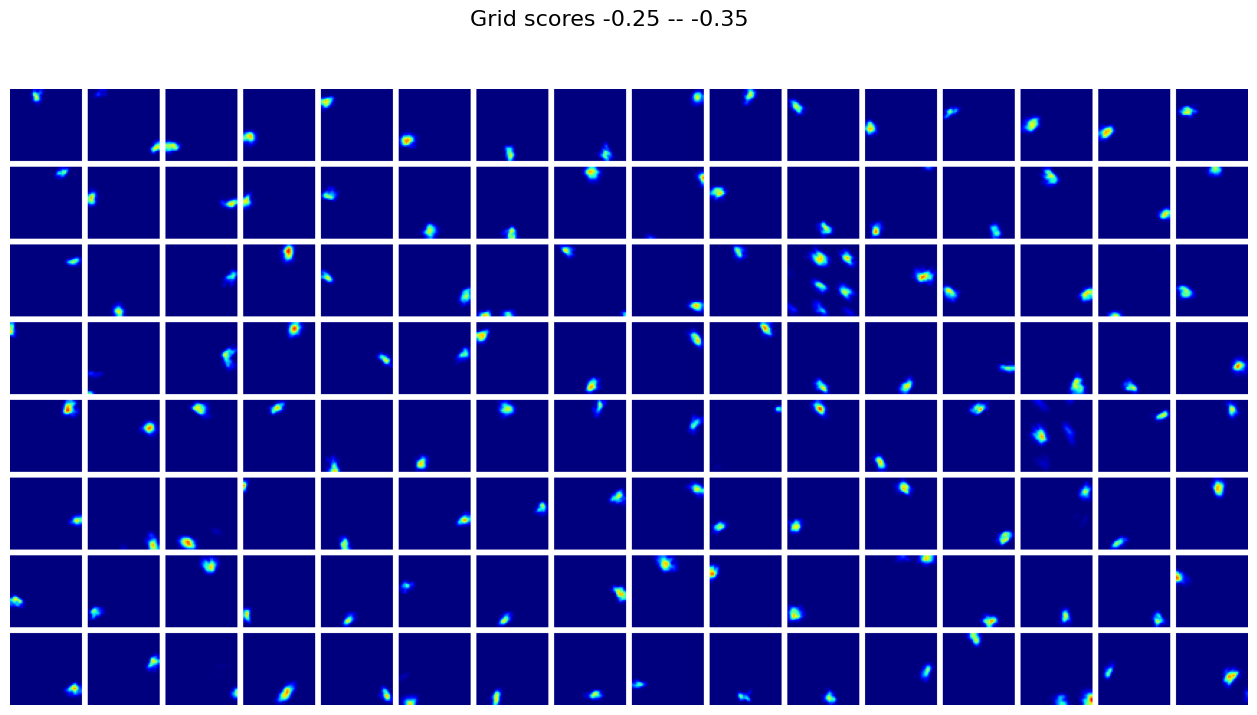

In [12]:
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[0]], 2))
             +' -- '+ str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot medium grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs[Ng//4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[Ng//2]], 2))
             +' -- ' + str(np.round(score_60[idxs[Ng//2+n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot low grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[-n_plot]], 2))
             +' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off');

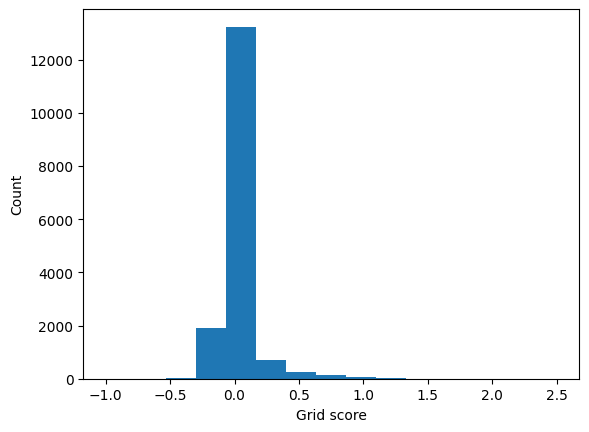

In [13]:
plt.hist(score_60, range=(-1,2.5), bins=15);
plt.xlabel('Grid score')
plt.ylabel('Count');

# Manifold distance

In [14]:
activations.shape, rate_map.shape, g.shape

((16384, 50, 50), (16384, 2500), (200000, 16384))

Text(0.5, 0.98, 'Manifold Distance')

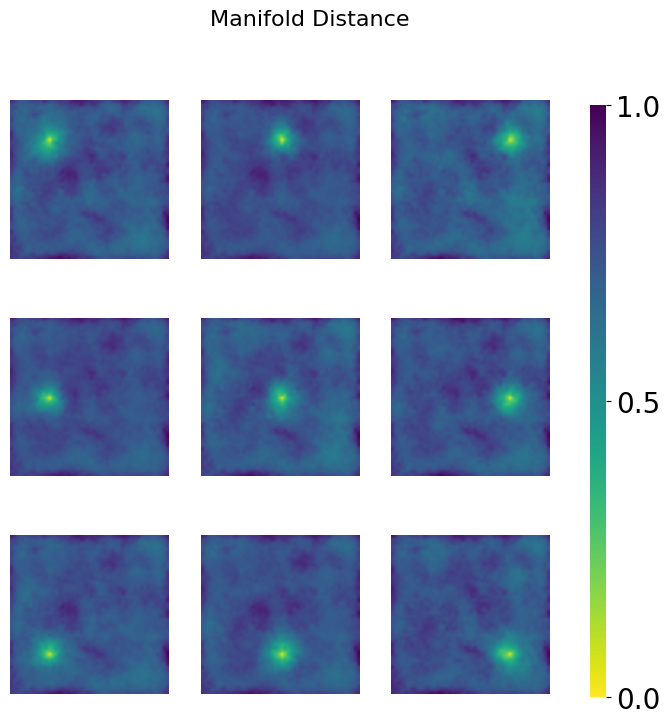

In [15]:
# Keeping all grid cells
origins = np.stack(np.mgrid[:3,:3] - 1) * res//4 + res//2

fig = plt.figure(figsize=(8,8))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        origin=np.random.randint(0,100,2)
        origin_idx = np.ravel_multi_index((origins[0,i,j],origins[1,i,j]), (res,res))
        r0 = rate_map[:,origin_idx,None]
        dists = np.linalg.norm(r0 - rate_map, axis=0)
        im = plt.imshow(dists.reshape(res,res)/np.max(dists),
                        cmap='viridis_r', interpolation='gaussian')
        plt.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.74])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.locator_params(nbins=3)
cbar.ax.tick_params(labelsize=20) 
cbar.outline.set_visible(False)
plt.suptitle('Manifold Distance', fontsize=16)

Text(0.5, 0.98, 'Manifold Distance. Top 50')

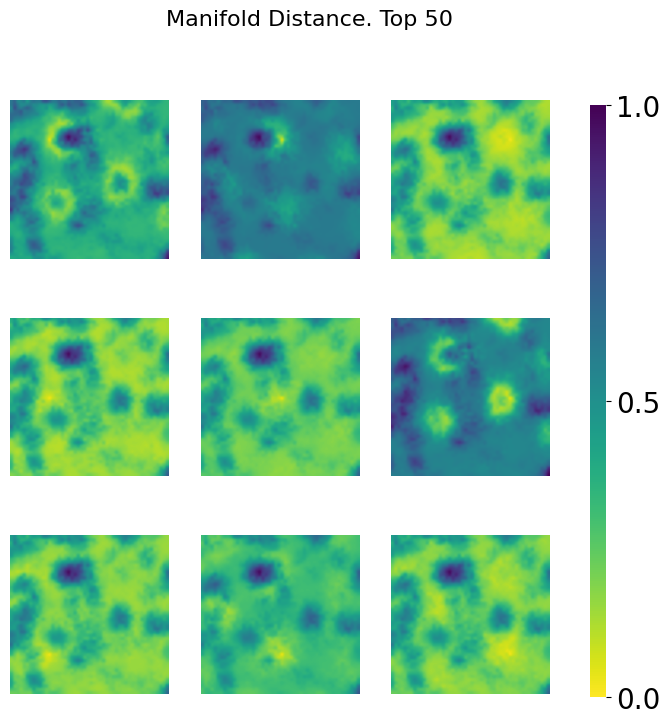

In [16]:
# Keeping only top 500 grid cells
n_grid_cells = 50
grid_sort = np.flip(np.argsort(score_60))
origins = np.stack(np.mgrid[:3,:3] - 1) * res//4 + res//2

fig = plt.figure(figsize=(8,8))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        origin=np.random.randint(0,100,2)
        origin_idx = np.ravel_multi_index((origins[0,i,j],origins[1,i,j]), (res,res))
        r0 = rate_map[grid_sort[:n_grid_cells],origin_idx,None]
        dists = np.linalg.norm(r0 - rate_map[grid_sort[:n_grid_cells]], axis=0)
        im = plt.imshow(dists.reshape(res,res)/np.max(dists),
                        cmap='viridis_r', interpolation='gaussian')
        plt.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.74])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.locator_params(nbins=3)
cbar.ax.tick_params(labelsize=20) 
cbar.outline.set_visible(False)
plt.suptitle(f'Manifold Distance. Top {n_grid_cells}', fontsize=16)

# Neural sheet

In [17]:
# Fourier transform 
rm_fft_real = np.zeros([Ns,res,res])
rm_fft_imag = np.zeros([Ns,res,res])

for i in tqdm(range(Ns)):
    rm_fft_real[i] = np.real(np.fft.fft2(rate_map[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(rate_map[i].reshape([res,res])))
    
rm_fft = rm_fft_real + 1j * rm_fft_imag

100%|██████████| 16384/16384 [00:00<00:00, 16975.51it/s]


In [18]:
rm_fft.shape

(16384, 50, 50)

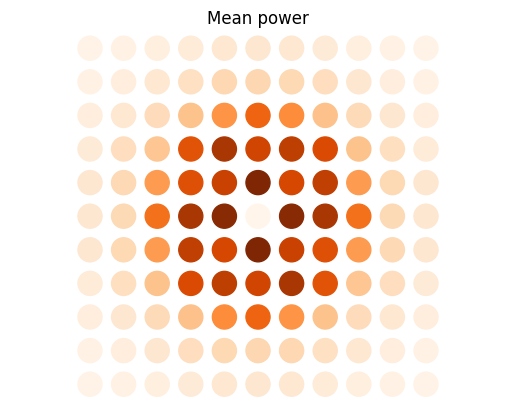

In [19]:
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
im = (np.real(rm_fft)**2).mean(0) # SHOULD THIS BE np.abs INSTEAD??
im[0,0] = 0
plt.scatter(x2,y2,c=im[idxs][:,idxs], s=300, cmap='Oranges')
plt.axis('equal')
plt.axis('off');
plt.title('Mean power');

In [20]:
k1 = [3,0]   # Horizontal component
k2 = [2,3]   # 60° component
k3 = [-1,3]  # 120° component
k4=k5=k6=k1  # Additional copies (possibly for analysis)

freq = 1
ks = freq*np.array([k1,k2,k3,k4,k5,k6])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])

In [21]:
modes.shape

(6, 16384)

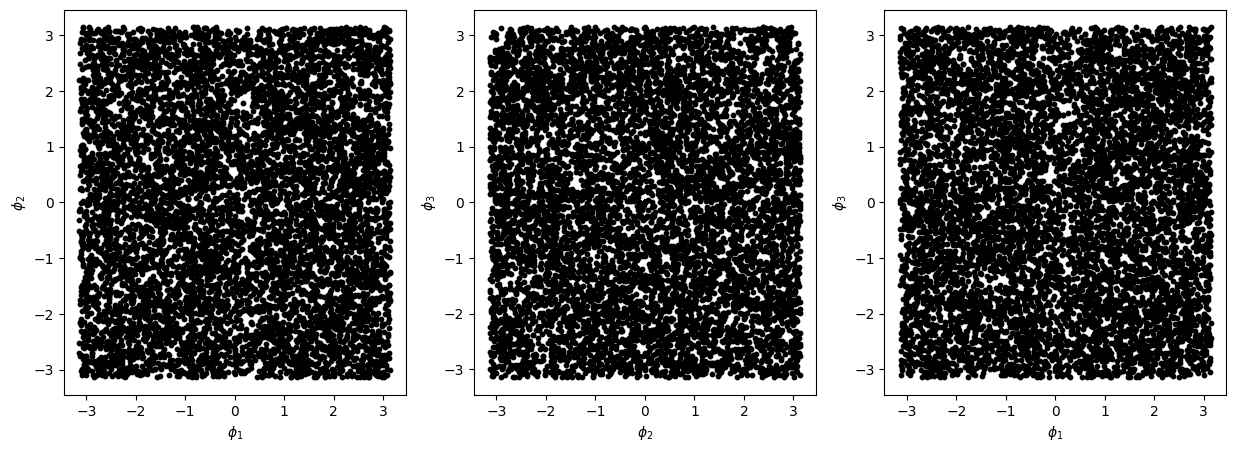

In [22]:
# Find phases
phases = [np.angle(mode) for mode in modes]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phases[0], phases[1], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phases[1], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phases[0], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.show()

Text(0.5, 0, '$\\phi_3$')

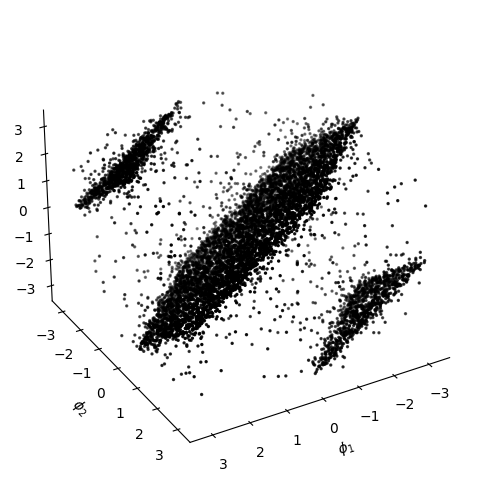

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(phases[0], phases[1], phases[2], c='black', s=2)
ax.view_init(azim=60)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_zlabel(r'$\phi_3$')

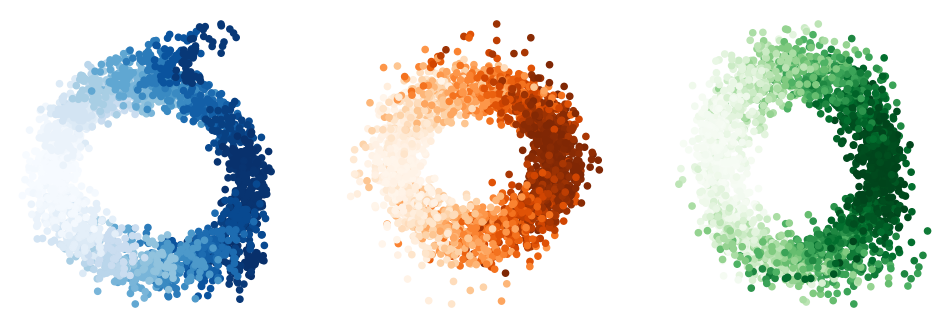

In [24]:
freq = 1
crop = 0
cmaps = ['Blues', 'Oranges', 'Greens']
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@rate_map
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20)
    plt.axis('off')

In [25]:
import scipy
X = rate_map - rate_map.mean(-1,keepdims=True)
X -= X.mean(-1, keepdims=True)
Ua, S, V = scipy.linalg.svd(X)

rm_embed = Ua.T@rate_map

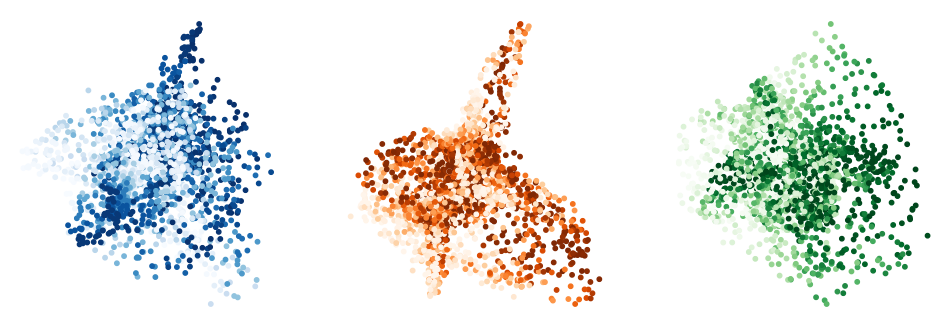

In [26]:
# Construct torus
# k1 = [1,0]
# k2 = [0.5, 0.5*np.sqrt(3)]
# k3 = np.array([-0.5, 0.5*np.sqrt(3)]) 

k1 = [3,0]
k2 = [2,2.5]
k3 = [-1,2.3]

# k1 = [1,0]
# k2 = [2,2.5]
# k3 = [-1,2.3]

freq = 1
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
cmaps = ['Blues', 'Oranges', 'Greens']

crop = 0
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

# Find rotation
RM = rm_embed[:10, idxs]
X_crop = X[:,idxs]
R = np.linalg.inv(RM.dot(RM.T)).dot(RM).dot(X_crop.T).T

# Lowdin symmetric orthogonalization 
U,s,V = np.linalg.svd(R)
S2 = U.dot(np.diag(1./s)).dot(U.T)
R = S2.dot(R)

# Plot rings
plt.figure(figsize=(12,4))
for i in range(R.shape[0]//2):
    plt.subplot(1,3,i+1)
    plt.scatter(R.dot(RM)[i], R.dot(RM)[i+3], c=X[i][idxs], cmap=cmaps[i], s=10)
    plt.axis('off')
    
# plt.savefig(folder + 'ring_fit.png')

In [36]:
top_n_rate_map = rate_map[grid_sort[:10],:]
top_n_rate_map.shape

(10, 2500)

In [37]:
top_n_rate_map

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.84845408e-03, 1.10430110e-02, ...,
        9.29801168e-02, 2.35851031e-01, 5.45207535e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.14292973e-02, 6.06731621e-03, 3.41905861e-03],
       ...,
       [2.84601350e-03, 2.92948846e-03, 2.92515182e-03, ...,
        3.26697653e-02, 1.84266813e-02, 2.30510703e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.56087727e-04, 0.00000000e+00, 0.00000000e+00],
       [9.46433342e-03, 1.19757014e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [57]:
# get non-zero rate maps
non_zero_rate_map = rate_map[:, np.sum(rate_map, axis=0) > 0]
non_zero_rate_map.shape


(16384, 2500)

In [58]:
np.sum(rate_map, axis=0).shape

(2500,)

In [68]:
extract_central_square(rate_map).T.shape

(1156, 16384)

In [28]:
rate_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1" 

In [28]:
from visualize import visualize_umap_3d, create_interactive_3d_plot

def extract_central_square(rate_map, size_ratio=0.7):
    """Extract central square from each rate map to avoid edge artifacts"""
    res = int(np.sqrt(rate_map.shape[1]))
    center = res // 2
    half_size = int(res * size_ratio // 2)
    
    indices_i = np.arange(center - half_size, center + half_size)
    indices_j = np.arange(center - half_size, center + half_size)
    
    grid_i, grid_j = np.meshgrid(indices_i, indices_j)
    indices = np.ravel_multi_index((grid_i.flatten(), grid_j.flatten()), (res, res))
    
    return rate_map[:, indices]

fig, ax, embedding = visualize_umap_3d(extract_central_square(rate_map).T, use_pca_first=True, pca_components=6, random_state=42)
interactive_fig = create_interactive_3d_plot(embedding)
interactive_fig.show()

Applying PCA to reduce dimensions from 16384 to 6...
Explained variance with 6 components: 32.35%
Applying UMAP to create 3D visualization...


/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


TypingError: Failed in nopython mode pipeline (step: native lowering)
Failed in nopython mode pipeline (step: nopython frontend)
Unknown attribute 'pow' of type Module(<module 'math' from '/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/lib-dynload/math.cpython-311-darwin.so'>)

File "../../anaconda3/envs/ganguli/lib/python3.11/site-packages/numba/cpython/numbers.py", line 236:
    def int_power(a, b):
        <source elided>
            # Optimization cutoff: fallback on the generic algorithm
            return math.pow(a, float(b))
            ^

During: typing of get attribute at /Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/numba/cpython/numbers.py (236)

File "../../anaconda3/envs/ganguli/lib/python3.11/site-packages/numba/cpython/numbers.py", line 236:
    def int_power(a, b):
        <source elided>
            # Optimization cutoff: fallback on the generic algorithm
            return math.pow(a, float(b))
            ^

During: lowering "$binop_pow130.16 = $118binary_subscr.14 ** $const128.15" at /Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/umap/distances.py (563)

In [112]:
from utils import get_2d_sort
import scipy

In [113]:
N = rate_map.shape[0]
n = int(np.sqrt(N))
width = int(np.sqrt(N))
freq = 1
X,Y = np.meshgrid(np.arange(width),np.arange(width))
X = X*2*np.pi/width
Y = Y*2*np.pi/width

s1 = np.zeros(phases[0].shape)
s2 = np.zeros(phases[0].shape)

fac = np.sqrt(3)/2

for i in range(Ns):
    penalty_1 = np.cos(freq*X - phases[0][i]/fac)
    penalty_2 = np.cos(freq*Y - phases[2][i]/fac)
    penalty_3 = np.cos(freq*(X+Y) - phases[1][i]/fac)
    ind = np.argmax(penalty_1+penalty_2 + penalty_3  + np.random.randn()/100)
    s1[i],s2[i] = np.unravel_index([ind],penalty_1.shape)
    
total_order = get_2d_sort(s1,s2)
rm_sort_square = rate_map[total_order.ravel()].reshape([n,n,-1])

/var/folders/_1/cpmb1f851qxc0ldc_pqv6vjw0000gn/T/ipykernel_1734/3875572618.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1[i],s2[i] = np.unravel_index([ind],penalty_1.shape)


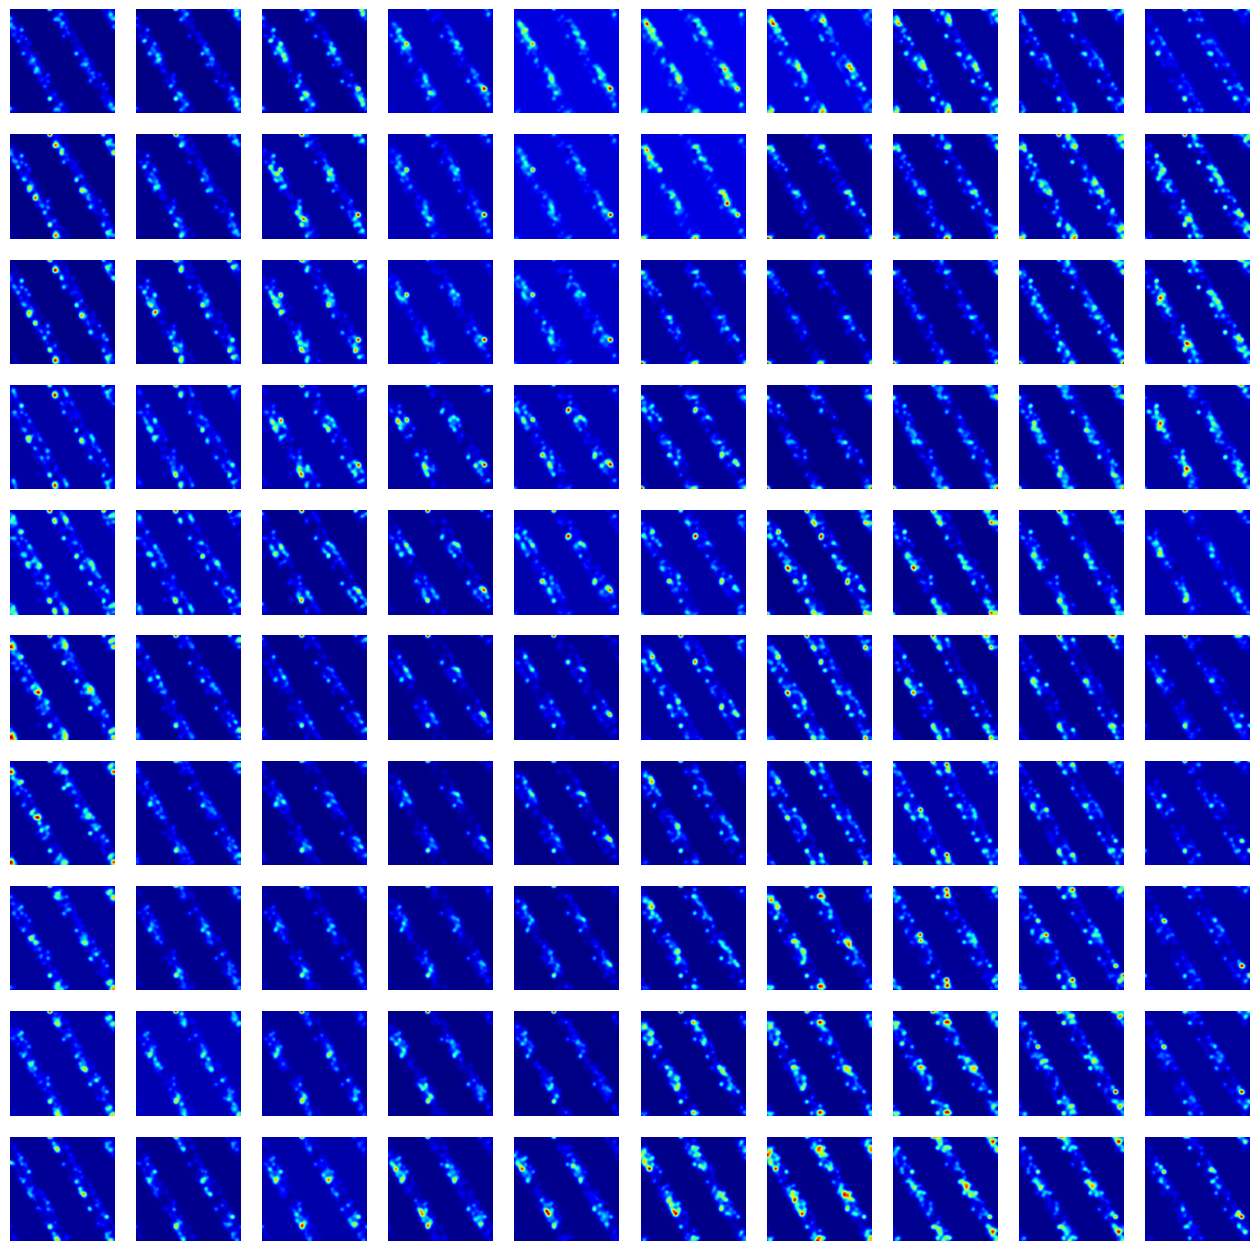

In [114]:
# Skew matrix to transform parallelogram unit cells to squares
A = np.asarray([[2,1],[0, np.sqrt(3)]])/4
Ainv = np.linalg.inv(A)

freq = 2
nplots=10
fig, axes = plt.subplots(nplots,nplots, figsize=(16,16))
for i in range(nplots):
    for j in range(nplots):
        idx = np.ravel_multi_index(((i+nplots//2)*res//nplots//freq,
                                    (j+nplots//2)*res//nplots//freq), (res,res))
        im = rm_sort_square[:,:,idx]
        im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
        im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
        axes[j,i].imshow(im.T, cmap='jet')
        axes[j,i].axis('off')